# ***ML_Project ***

In [106]:
# -*- coding: utf-8 -*-
"""
Project: House Price Prediction Pipeline
Description: This script implements a complete data science pipeline for predicting house prices.
             It includes data loading, exploratory data analysis (EDA), data cleaning,
             feature engineering, model training (with LightGBM and XGBoost), and submission file generation.
"""

# =============================================================================
# 1. SETUP: MOUNT DRIVE & INSTALL REQUIRED PACKAGES (Colab-specific)
# =============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install scikit-learn==1.2.2 xgboost==1.7.6
!pip install lightgbm==3.3.2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
# =============================================================================
# 2. IMPORT LIBRARIES
# =============================================================================
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
import xgboost as xgb



In [108]:
# =============================================================================
# 3. LOAD DATA
# =============================================================================
# Update file paths accordingly from your Google Drive
file_path_train = '/content/drive/Shareddrives/gizbar/train.csv'
file_path_test  = '/content/drive/Shareddrives/gizbar/test.csv'

train_raw = pd.read_csv(file_path_train)
test_raw  = pd.read_csv(file_path_test)

## **EDA**

In [109]:
# =============================================================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

# --- 4.1 Summary Statistics for Key Features ---
key_features = [
    'full_sq', 'life_sq', 'kitch_sq', 'num_room',
    'floor', 'max_floor', 'build_year', 'material', 'state', 'price_doc'
]
print("Summary Statistics for Key Features:")
print(train_raw[key_features].describe())

Summary Statistics for Key Features:
            full_sq       life_sq      kitch_sq      num_room         floor  \
count  30471.000000  24088.000000  20899.000000  20899.000000  30304.000000   
mean      54.214269     34.403271      6.399301      1.909804      7.670803   
std       38.031487     52.285733     28.265979      0.851805      5.319989   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       38.000000     20.000000      1.000000      1.000000      3.000000   
50%       49.000000     30.000000      6.000000      2.000000      6.500000   
75%       63.000000     43.000000      9.000000      2.000000     11.000000   
max     5326.000000   7478.000000   2014.000000     19.000000     77.000000   

          max_floor    build_year      material         state     price_doc  
count  20899.000000  1.686600e+04  20899.000000  16912.000000  3.047100e+04  
mean      12.558974  3.068057e+03      1.827121      2.107025  7.123035e+06  
std        6.7565

We performed descriptive statistics for the parameters we identified as important to the model. From this initial analysis, we already noticed issues with the data. For example, the maximum value of LIFE_SQ is larger than the maximum value of FULL_SQ, which is logically inconsistent. Additionally, the maximum value of KITCH_SQ is unrealistically large, indicating that these values do not represent real-world scenarios. These problematic cases will need to be addressed during the data cleaning process.

In [110]:
# --- 4.2 Missing Value Analysis ---
missing_percentages = train_raw[key_features].isnull().mean() * 100
print("\nMissing Value Percentages for Key Features:")
print(missing_percentages)


Missing Value Percentages for Key Features:
full_sq        0.000000
life_sq       20.947786
kitch_sq      31.413475
num_room      31.413475
floor          0.548062
max_floor     31.413475
build_year    44.649011
material      31.413475
state         44.498047
price_doc      0.000000
dtype: float64


After examining the important parameters, we observed that some of them have a very high proportion of missing values. This will require further investigation to determine whether and how these missing values should be imputed during the data preprocessing stage.

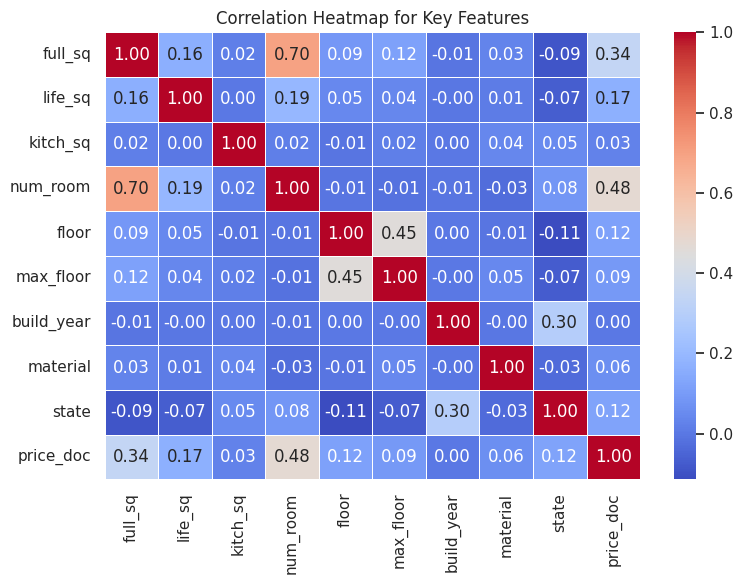

In [111]:
# --- 4.3 Correlation Heatmap for Key Features and Target ---
selected_features = key_features  # Including the target: price_doc
corr_matrix = train_raw[selected_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for Key Features")
plt.tight_layout()
plt.show()

We created a correlation matrix to analyze the relationships between the parameters and also their correlation with the target variable. The results show that there is no particularly high correlation between most parameters, which helps prevent multicollinearity issues. However, there is a notable but borderline high correlation between NUM_ROOM and FULL_SQ. In terms of correlation with the target variable, FULL_SQ and NUM_ROOM exhibit the strongest relationships, suggesting that these features are likely to have the most significant impact on our model. Other parameters seem to have weaker correlations with the target variable and might have a smaller influence.

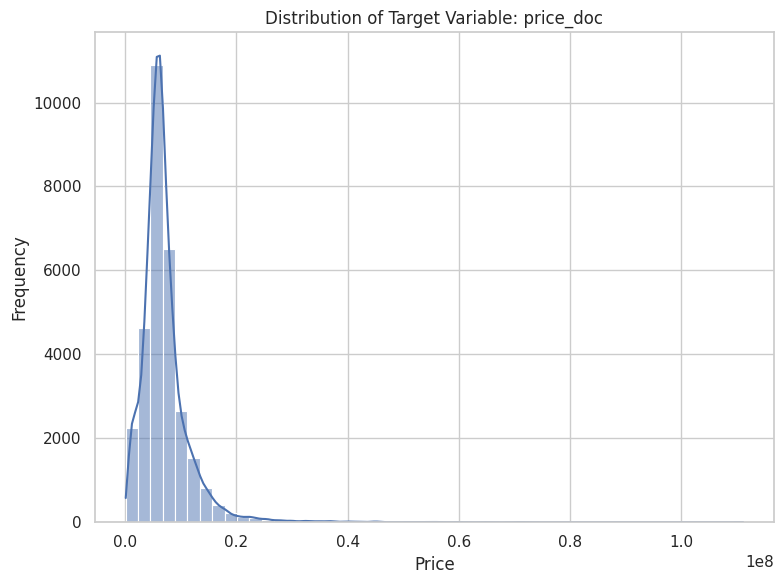

In [112]:
# --- 4.4 Distribution of the Target Variable (price_doc) ---
plt.figure(figsize=(8, 6))
sns.histplot(train_raw['price_doc'], bins=50, kde=True)
plt.title("Distribution of Target Variable: price_doc")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

From the histogram results, we can observe that most of the prices fall between 0 and 20 million. However, there are a few values that are likely errors, as the histogram appears to "stretch" significantly to the right. This indicates the presence of extremely high prices that are likely outliers or data entry errors.

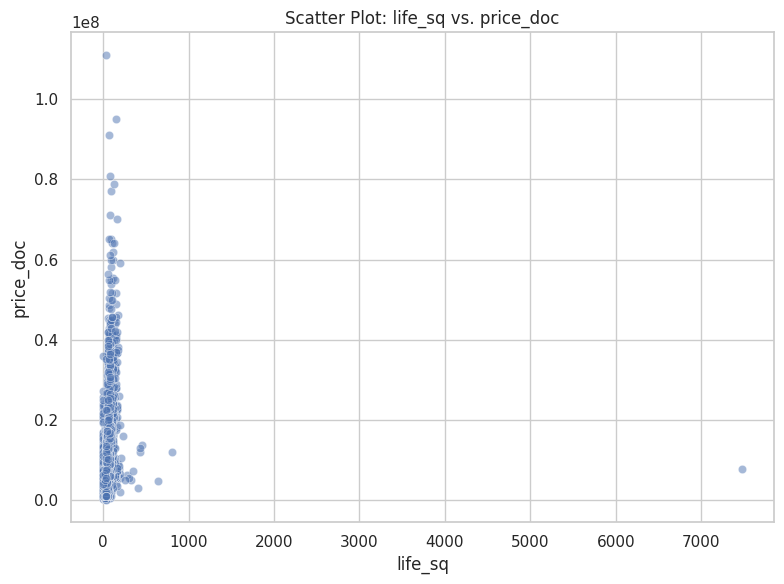

In [113]:
# --- 4.5 Scatter Plots ---
# Scatter: life_sq vs. price_doc
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_raw['life_sq'], y=train_raw['price_doc'], alpha=0.5)
plt.title("Scatter Plot: life_sq vs. price_doc")
plt.xlabel("life_sq")
plt.ylabel("price_doc")
plt.tight_layout()
plt.show()

In the scatter plot, we can also observe a significantly high value that is likely an error. Therefore, we will address this outlier and remove it in subsequent steps.

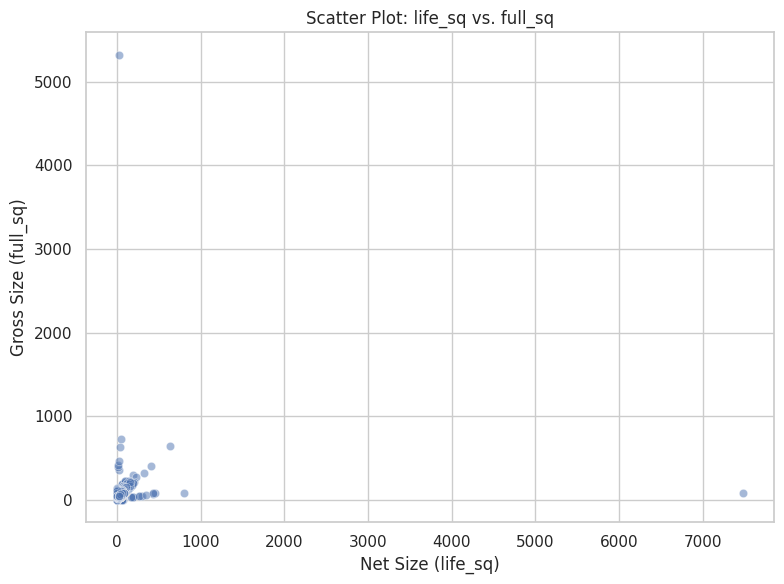

In [114]:
# Scatter: life_sq vs. full_sq
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_raw['life_sq'], y=train_raw['full_sq'], alpha=0.5)
plt.title("Scatter Plot: life_sq vs. full_sq")
plt.xlabel("Net Size (life_sq)")
plt.ylabel("Gross Size (full_sq)")
plt.tight_layout()
plt.show()

Here, we aimed to examine the relationship between net size (life_sq) and gross size (full_sq). The plot reveals several inconsistencies for the following reasons:

1. The net size cannot be larger than the gross size, yet this occurs frequently in the data.
2. It is highly unlikely for apartments to have a size smaller than 10 square meters, which is also observed in the data.

We will need to address and correct these issues in the following steps.

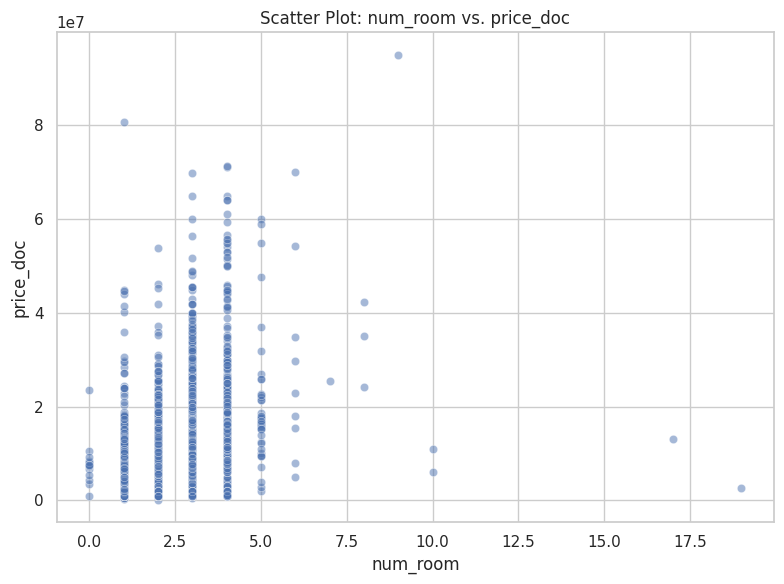

In [115]:
# Scatter: num_room vs. price_doc
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_raw['num_room'], y=train_raw['price_doc'], alpha=0.5)
plt.title("Scatter Plot: num_room vs. price_doc")
plt.xlabel("num_room")
plt.ylabel("price_doc")
plt.tight_layout()
plt.show()

Here, we can observe some outliers as it seems unlikely that most apartments have between 0 to 9 rooms, with a few extreme values standing out. To address this, we will need to verify whether these values are reasonable based on the apartment sizes and subsequently edit or remove these observations as necessary.

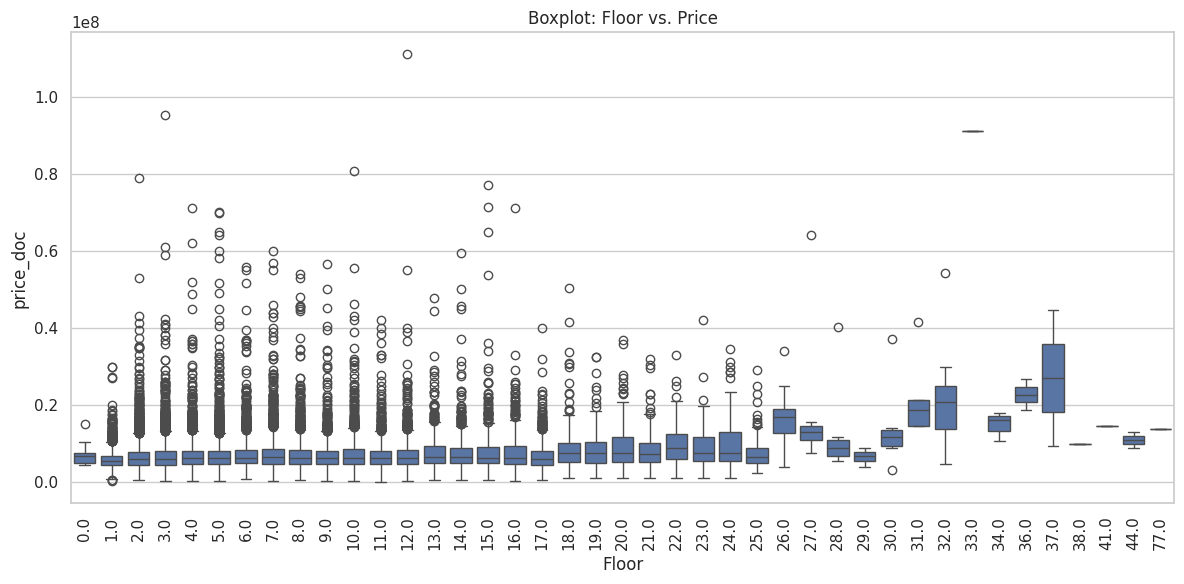

In [116]:
# --- 4.6 Boxplots ---
# Boxplot: Floor vs. Price
plt.figure(figsize=(12, 6))
sns.boxplot(x='floor', y='price_doc', data=train_raw)
plt.title("Boxplot: Floor vs. Price")
plt.xlabel("Floor")
plt.ylabel("price_doc")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In this box plot of apartment floor levels, we can see that nearly all apartments are located between floors 0 and 44. However, there is a single observation at floor 77, which is likely an error. It would be reasonable to correct this value to 7, as it seems to be a misentry.

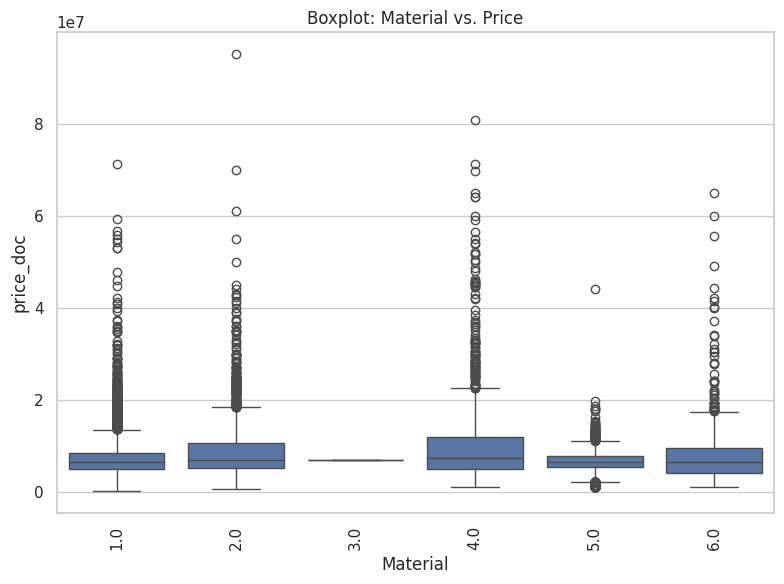

In [117]:
# Boxplot: Material vs. Price
plt.figure(figsize=(8, 6))
sns.boxplot(x='material', y='price_doc', data=train_raw)
plt.title("Boxplot: Material vs. Price")
plt.xlabel("Material")
plt.ylabel("price_doc")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Here, in the material type of the building, it is unlikely that there is a single apartment categorized as type 3. This suggests a probable data entry error. It would be best to either correct this value or remove the observation to maintain data consistency.

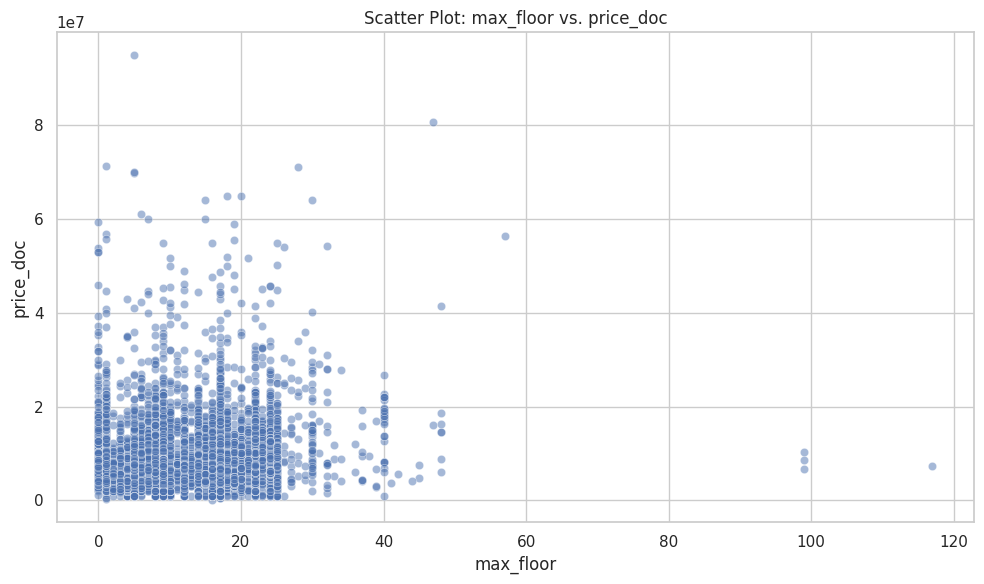

In [118]:
# --- 4.7 Additional Visualizations ---
# Scatter: max_floor vs. price_doc
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_raw['max_floor'], y=train_raw['price_doc'], alpha=0.5)
plt.title("Scatter Plot: max_floor vs. price_doc")
plt.xlabel("max_floor")
plt.ylabel("price_doc")
plt.tight_layout()
plt.show()

In the graph showing the maximum floor of buildings, we can see some extreme values ranging between 99 and 117. Logically, apartments in such high-rise buildings would likely be more expensive, but in this case, their prices appear to be in the normal range compared to other observations. This suggests that these values are likely errors. To correct this, we will adjust 99 to 9 and 117 to either 11 or 17, making them more reasonable within the dataset.

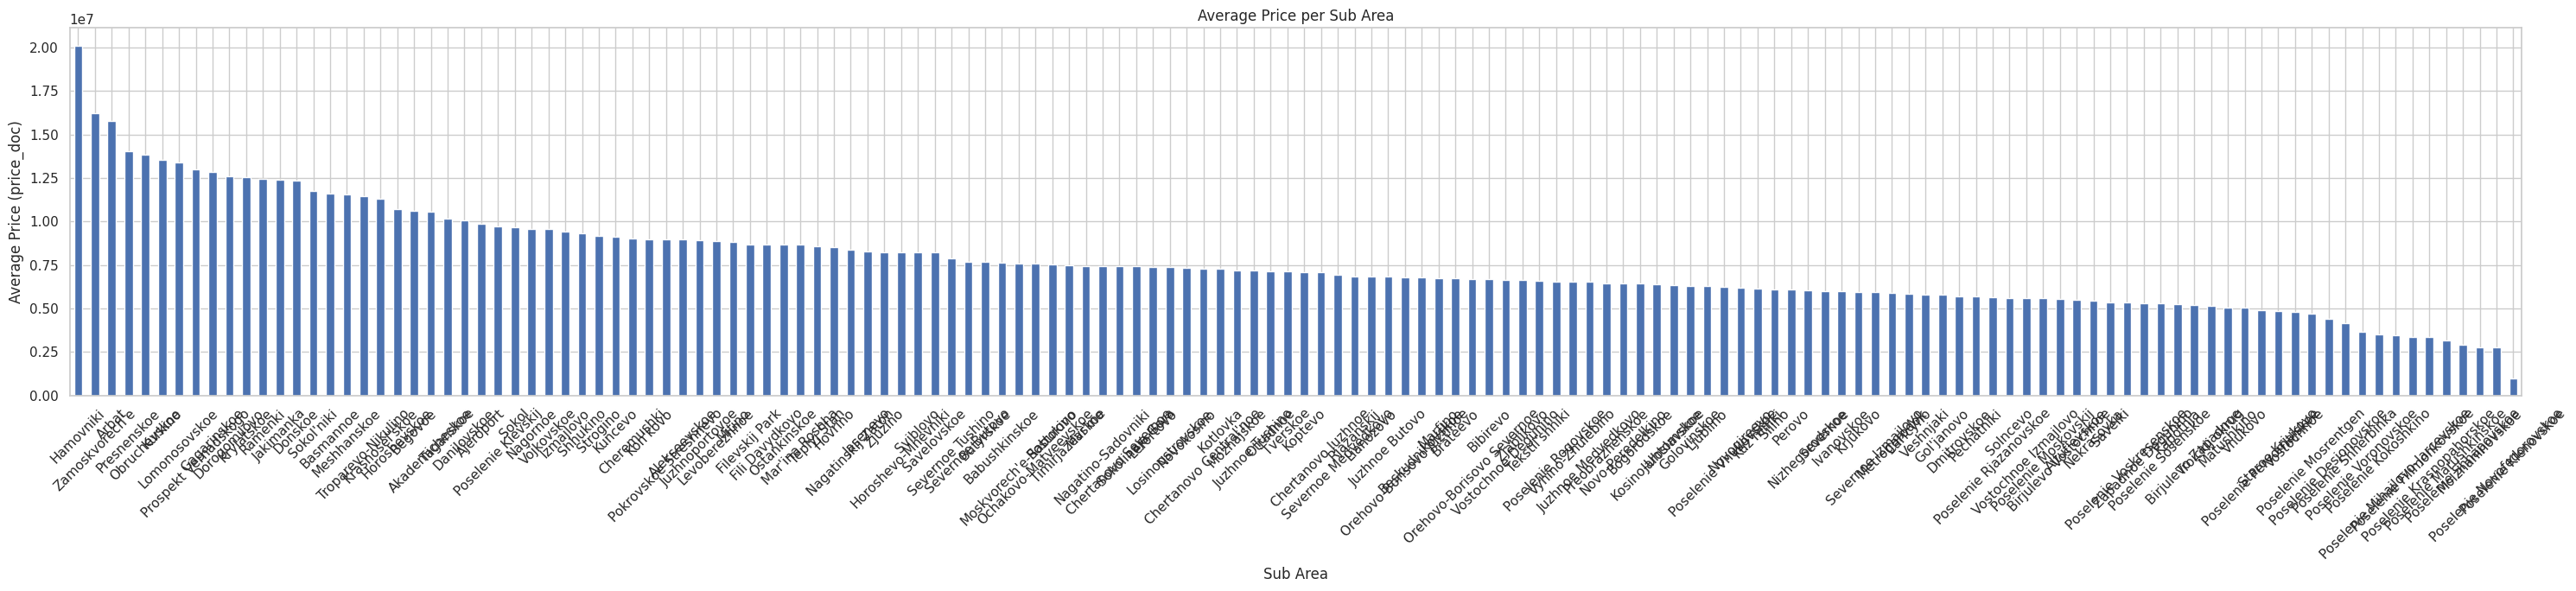

In [119]:
# Bar Chart: Average Price per Sub Area (if available)
if 'sub_area' in train_raw.columns:
    avg_price_per_area = train_raw.groupby('sub_area')['price_doc'].mean().sort_values(ascending=False)
    plt.figure(figsize=(30, 7))
    avg_price_per_area.plot(kind='bar')
    plt.title("Average Price per Sub Area")
    plt.xlabel("Sub Area")
    plt.ylabel("Average Price (price_doc)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'sub_area' not found in the dataset.")

We conducted an analysis of the average price per district to identify the most expensive areas. It is reasonable to assume that location significantly impacts apartment prices, similar to trends seen in other real estate markets. For example, in Israel, properties closer to the city center tend to be more expensive, while those in the Negev region are generally more affordable. This insight will help us understand the geographical influence on pricing and improve our model's predictive accuracy.

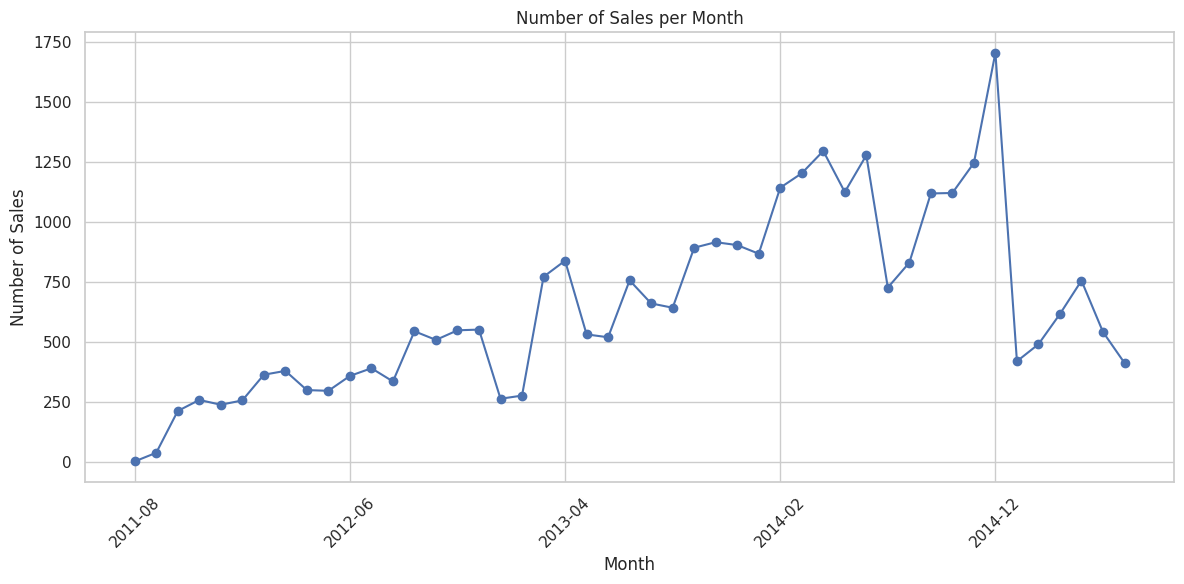

In [120]:
# Time Series: Sales Count per Month (if timestamp is available)
if 'timestamp' in train_raw.columns:
    train_raw['timestamp'] = pd.to_datetime(train_raw['timestamp'])
    train_raw['year_month'] = train_raw['timestamp'].dt.to_period('M').astype(str)
    sales_per_month = train_raw['year_month'].value_counts().sort_index()
    plt.figure(figsize=(12, 6))
    sales_per_month.plot(kind='line', marker='o')
    plt.title("Number of Sales per Month")
    plt.xlabel("Month")
    plt.ylabel("Number of Sales")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


A graph showing the number of transactions per month can help us analyze whether periods of high transaction volume impact apartment prices. It is possible that during months with a surge in transactions, prices fluctuate due to increased demand or seasonal trends. By visualizing the transaction growth rate over time, we can gain insights into potential market patterns that may affect pricing.

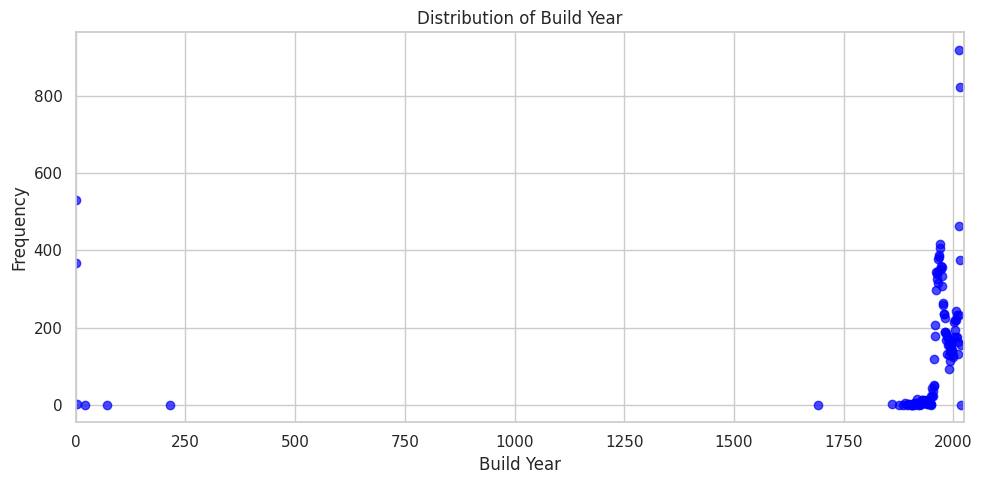

In [121]:
# Distribution of Build Year (focus on realistic years)
if 'build_year' in train_raw.columns:
    build_year_counts = train_raw['build_year'].dropna().value_counts().sort_index()
    plt.figure(figsize=(10, 5))
    plt.scatter(build_year_counts.index, build_year_counts.values, alpha=0.7, color='blue')
    plt.title("Distribution of Build Year")
    plt.xlabel("Build Year")
    plt.ylabel("Frequency")
    plt.xlim(0, 2025)
    plt.tight_layout()
    plt.show()

A scatter plot displaying the construction years recorded in our dataset reveals clear errors. Firstly, some values are 0, which is definitely incorrect. Secondly, there are entries with years below 250, which is entirely unrealistic. To correct these inaccuracies, we will remove all observations with construction years below 1500 and replace them with NaN to ensure data integrity.

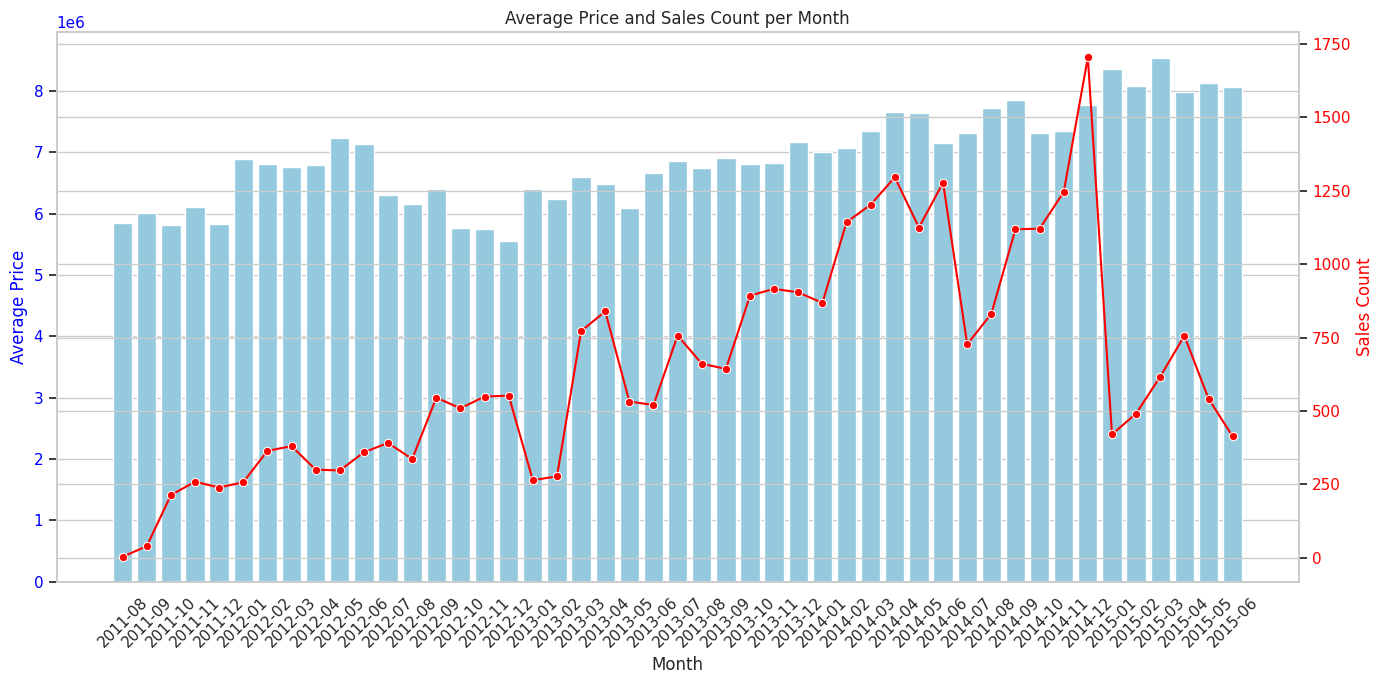

In [122]:
# 1) Group by month (derived from 'timestamp') to get average price and count
monthly_data = (
    train_raw
    .groupby(train_raw['timestamp'].dt.to_period('M'))['price_doc']
    .agg(['mean', 'count'])   # 'mean' for average price, 'count' for number of sales
    .reset_index()
)

# Convert the period (YYYY-MM) to string for plotting on the x-axis
monthly_data['month_str'] = monthly_data['timestamp'].astype(str)

# 2) Use a Seaborn style
sns.set(style='whitegrid')

# 3) Create the figure and primary axis (for the Average Price bar chart)
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot a bar chart of the average price
sns.barplot(
    data=monthly_data,
    x='month_str',
    y='mean',
    color='skyblue',
    ax=ax1
)

ax1.set_xlabel("Month")
ax1.set_ylabel("Average Price", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='x', rotation=45)  # Rotate x labels for readability

# 4) Create a secondary y-axis (twin) for the Sales Count line chart
ax2 = ax1.twinx()

sns.lineplot(
    data=monthly_data,
    x='month_str',
    y='count',
    color='red',
    marker='o',
    ax=ax2
)

ax2.set_ylabel("Sales Count", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 5) Add a title and tighten layout
plt.title("Average Price and Sales Count per Month")
plt.tight_layout()
plt.show()

A combined histogram and line chart allows us to visualize both the growth rate of prices and the growth rate of transactions over time. By analyzing this relationship, we can determine whether an increase in transaction volume influences price changes. If a strong correlation exists, this insight could be valuable for forecasting future prices, as market demand fluctuations might serve as an indicator of price trends.

In [123]:
# =============================================================================
# 5. DATA PREPROCESSING & FEATURE ENGINEERING
# =============================================================================
def preprocess_data(df, is_train=True):
    """
    Clean and engineer features in the dataset.

    Parameters:
    -----------
    df : DataFrame
        Input DataFrame to preprocess.
    is_train : bool, default=True
        Indicates whether the DataFrame is training data.

    Returns:
    --------
    df : DataFrame
        Preprocessed DataFrame.
    """
    # --- Data Cleaning ---
    # Correct unrealistic values for living area
    df.loc[df['life_sq'] > df['full_sq'], 'life_sq'] = np.nan
    df.loc[(df['life_sq'] < 0.2 * df['full_sq']), 'full_sq'] = np.nan
    df.loc[df['life_sq'] < 9, 'life_sq'] = np.nan
    df.loc[(df['kitch_sq'] > 0.6 * df['life_sq']), 'kitch_sq'] = np.nan

    # Set specific unrealistic num_room values to NaN
    values_to_replace = [19, 17, 10, 9]
    df.loc[df['num_room'].isin(values_to_replace), 'num_room'] = np.nan

    # Handle unrealistic build_year values
    df.loc[(df['build_year'] < 1500) | (df['build_year'] > 2025), 'build_year'] = np.nan

    # Replace unusual values in state and material
    df['state'].replace({33: 3}, inplace=True)
    df['material'].replace({3: 1}, inplace=True)
    df["floor"].replace({77: 7}, inplace=True)
    df["max_floor"].replace({117: 11, 99: 9}, inplace=True)
    df["life_sq"].replace({7478: 74, 802: 80}, inplace=True)

    # For training data, replace extreme price_doc values with the median
    if is_train and 'price_doc' in df.columns:
        avg_price = df['price_doc'].median()
        df['price_doc'] = np.where(
            df['price_doc'].isin([df['price_doc'].min(), df['price_doc'].max()]),
            avg_price,
            df['price_doc']
        )

    # Replace zero values with NaN in key columns
    df['full_sq'].replace(0, np.nan, inplace=True)
    df['max_floor'].replace(0, np.nan, inplace=True)
    df['num_room'].replace(0, np.nan, inplace=True)

    # --- Feature Engineering ---
    # Create year-month feature from timestamp
    df['year_mo'] = pd.to_datetime(df['timestamp']).dt.to_period('M').astype(str)
    df['year_month'] = df['year_mo']

    # Ratio of living area to total area
    df['resident_to_total_ratio'] = df['life_sq'] / df['full_sq']

    # Count of sales per month
    sales_per_month = df['year_mo'].value_counts()
    df['n_sales_month'] = df['year_mo'].map(sales_per_month)

    # Relative floor: floor divided by max_floor
    df['floor_rel_total'] = df['floor'] / df['max_floor']

    # Labor force percentage
    df['pct_labor_force'] = df['work_all'] / df['raion_popul']

    # Average room area
    df['avg_room_area'] = df['life_sq'] / df['num_room']

    # Extra area (difference between full and living area)
    df['extra_area'] = df['full_sq'] - df['life_sq']

    # Extract year from timestamp
    df['year'] = pd.to_datetime(df['timestamp']).dt.year

    # Create apartment name feature: sub_area + rounded metro distance
    df['apt_name'] = df['sub_area'] + '_' + df['metro_km_avto'].round(1).astype(str)
    df['apt_name_yrmo'] = df['apt_name'] + '_' + df['year_mo']

    # Extra area ratio: extra_area / full_sq
    df['extra_area_ratio'] = df['extra_area'] / df['full_sq']

    # Count of missing values per row
    df['count_nan_per_row'] = df.isna().sum(axis=1)

    # Distance from sub_area to Kremlin: average kremlin_km by sub_area
    dist_per_subarea = df.groupby('sub_area')['kremlin_km'].mean().rename('subarea_dist_to_kremlin')
    df = df.merge(dist_per_subarea, on='sub_area', how='left')

    # Mean building height per sub_area
    height_per_subarea = df.groupby('sub_area')['max_floor'].mean().rename('mean_bldg_height')
    df = df.merge(height_per_subarea, on='sub_area', how='left')

    # Flag for small buildings (max_floor <= 20)
    df['small_flag'] = (df['max_floor'] <= 20).astype(int)

    # Drop timestamp as it is no longer needed
    df.drop('timestamp', axis=1, inplace=True)

    # Remove any ID columns except for 'id'
    id_cols = [col for col in df.columns if 'ID' in col and col != 'id']
    df.drop(columns=id_cols, inplace=True, errors='ignore')

    return df

# Preprocess training and test data
train = preprocess_data(train_raw, is_train=True)
test_processed = preprocess_data(test_raw, is_train=False)

# Preserve test IDs for submission
test_ids = test_raw['id'].copy()

In this section, we perform data cleaning and feature engineering to improve the quality of the dataset before training our model. Below is a breakdown of the key modifications and why they are necessary:

1. Data Cleaning

Handling unrealistic values:

- If [life_sq] (net area) is larger than [full_sq] (gross area), we set it to NaN as this is logically incorrect.
- Values of [life_sq] that are unrealistically small (below 9 sqm) are also set to NaN to avoid errors in predictions.
- [kitch_sq] values exceeding 60% of life_sq are marked as NaN since kitchens typically do not occupy such a large portion of an apartment.

- Fixing [num_room] anomalies Values like 9, 10, 17, and 19 for the number of rooms are likely erroneous and are replaced with NaN.
- Correcting [build_year]: We remove unrealistic values before the year 1500 and after 2025 to ensure a reasonable distribution.
- Fixing incorrect categorical values: Replacing extreme or incorrect values in [state], [material], [floor], and [max_floor] to maintain data consistency.
-Handling extreme [price_doc] values (only in training data): The lowest and highest prices are replaced with the median price to mitigate the impact of outliers on model training.

2. Feature Engineering

New features are created to capture key relationships in the dataset and enhance model predictive power:

- [year_month] Helps track seasonal trends in the real estate market.
- [resident_to_total_ratio] Provides insight into the efficiency of apartment space usage.
- [n_sales_month] Identifies market trends and fluctuations in demand.
- [floor_rel_total] Represents how high the apartment is compared to the building’s total floors, which can impact price.
- [pct_labor_force] Measures the percentage of the labor force in the area, indicating economic activity.
- [avg_room_area] Provides information on the average size of rooms in an apartment.
- [extra_area] Represents the difference between full and living area, indicating shared spaces or balconies.
- [apt_name] Combines [sub_area] and [metro_km_avto] (distance to metro) to account for location impact.
- [extra_area_ratio] Captures the percentage of non-living space relative to total apartment size.
- [count_nan_per_row] Counts the number of missing values in each row to detect problematic records.
- [subarea_dist_to_kremlin] Represents the average distance of a district from the Kremlin, which affects pricing.
- [mean_bldg_height] Stores the average building height per district, providing context on neighborhood density.
- [small_flag] A binary feature indicating whether a building has 20 floors or fewer.
3. Data Cleaning Adjustments
- Dropped [timestamp] after extracting the necessary time-related features.
- Removed unnecessary [ID] columns, keeping only relevant ones for modeling.

These enhancements improve the dataset by removing inconsistencies and adding meaningful variables to improve model performance.

In [124]:
# =============================================================================
# 6. TRAIN-VALIDATION SPLIT & TARGET TRANSFORMATION
# =============================================================================
# Apply log1p transformation to the target variable
train["price_doc"] = np.log1p(train["price_doc"])

# Separate features and target
X_train_full = train.drop("price_doc", axis=1)
y_train_full = train["price_doc"].copy()
X_test_full  = test_processed.copy()

# 80/20 Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test_full.shape)

Training set shape: (24376, 299) (24376,)
Validation set shape: (6095, 299) (6095,)
Test set shape: (7662, 299)


Data Preparation for Model Training

In this section, we prepare the dataset for model training, ensuring that all transformations are applied consistently across training, validation, and test sets. The key steps include:

1. Log Transformation of Target Variable

2. Splitting Data into Training and Validation Sets

3. Ensuring Feature Engineering Consistency


In [125]:
# =============================================================================
# 7. FULL PIPELINE: IMPUTATION, ENCODING & LIGHTGBM TRAINING
# =============================================================================
def full_pipeline(
    X_tr, X_val, y_tr, y_val, X_test_full,
    median_mode_cols=None,
    knn_columns=None,
    label_encode=True,
    remove_zero_importance=True,
    lgb_params=None,
    num_boost_round=1000,
    early_stopping_rounds=50
):
    """
    Full pipeline including:
    A) Median/Mode imputation.
    B) KNN imputation.
    C) Label encoding for categorical features.
    D) Removal of the ID column.
    E) LightGBM training with early stopping.
    F) Feature importance extraction and removal of zero-importance features.

    Returns:
    --------
    Processed training, validation, and test sets, the trained model, feature importance DataFrame,
    and list of removed features.
    """

    # --- A) Median/Mode Imputation ---
    if median_mode_cols is None:
        median_mode_cols = [
            'prom_part_5000', 'floor', 'railroad_station_walk_km', 'metro_min_walk',
            'metro_km_walk', 'railroad_station_walk_min', 'product_type',
            'green_part_2000', 'full_sq', 'floor_rel_total', 'max_floor', 'num_room',
            'material', 'preschool_quota', 'cafe_sum_1000_min_price_avg',
            'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000', 'extra_area',
            'resident_to_total_ratio', 'extra_area_ratio', 'life_sq',
            'build_count_before_1920', 'build_count_brick', 'build_count_1946-1970',
            'raion_build_count_with_builddate_info', 'build_count_monolith',
            'raion_build_count_with_material_info', 'cafe_avg_price_1500',
            'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_2000',
            'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg'
        ]

    impute_values_dict = {}
    for col in median_mode_cols:
        if col not in X_tr.columns:
            continue
        # For the categorical column 'product_type', use mode; otherwise, use median.
        if col == 'product_type':
            mode_val = X_tr[col].mode()[0] if X_tr[col].dropna().size > 0 else 'Investment'
            impute_values_dict[col] = mode_val
        else:
            impute_values_dict[col] = X_tr[col].median()

    for col, val in impute_values_dict.items():
        if col in X_tr.columns:
            X_tr[col].fillna(val, inplace=True)
        if col in X_val.columns:
            X_val[col].fillna(val, inplace=True)
        if col in X_test_full.columns:
            X_test_full[col].fillna(val, inplace=True)

    # --- B) KNN Imputation on Selected Columns ---
    if knn_columns is None:
        knn_columns = ['hospital_beds_raion', 'avg_room_area', 'state']

    knn_imputers = {}
    for col in knn_columns:
        if col not in X_tr.columns:
            continue
        imputer = KNNImputer(n_neighbors=5)
        X_tr[[col]] = imputer.fit_transform(X_tr[[col]])
        knn_imputers[col] = imputer

    for col, imputer in knn_imputers.items():
        if col in X_val.columns:
            X_val[[col]] = imputer.transform(X_val[[col]])
        if col in X_test_full.columns:
            X_test_full[[col]] = imputer.transform(X_test_full[[col]])

    # --- C) Label Encoding for Categorical Columns ---
    label_encoders = {}
    if label_encode:
        cat_cols = X_tr.select_dtypes(include=['object']).columns
        for c in cat_cols:
            le = LabelEncoder()
            X_tr[c] = X_tr[c].astype(str)
            le.fit(X_tr[c])
            X_tr[c] = le.transform(X_tr[c])
            label_encoders[c] = le

        for c, le in label_encoders.items():
            if c in X_val.columns:
                X_val[c] = X_val[c].astype(str).apply(lambda val: val if val in le.classes_ else '<unknown>')
                if '<unknown>' not in le.classes_:
                    le.classes_ = np.append(le.classes_, '<unknown>')
                X_val[c] = le.transform(X_val[c].astype(str))
            if c in X_test_full.columns:
                X_test_full[c] = X_test_full[c].astype(str).apply(lambda val: val if val in le.classes_ else '<unknown>')
                if '<unknown>' not in le.classes_:
                    le.classes_ = np.append(le.classes_, '<unknown>')
                X_test_full[c] = le.transform(X_test_full[c].astype(str))

    # --- D) Remove the 'id' Column if Present ---
    for dataset in [X_tr, X_val, X_test_full]:
        if "id" in dataset.columns:
            dataset.drop(columns=["id"], inplace=True)

    # --- E) LightGBM Model Training with Early Stopping ---
    if lgb_params is None:
        lgb_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 1,
            'seed': 42
        }

    train_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    def rmsle(preds, dataset):
        labels = dataset.get_label()
        preds = np.maximum(preds, 0)
        labels = np.maximum(labels, 0)
        rmsle_val = np.sqrt(mean_squared_log_error(labels, preds))
        return 'rmsle', rmsle_val, False

    model = lgb.train(
        params=lgb_params,
        train_set=train_data,
        num_boost_round=num_boost_round,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        early_stopping_rounds=early_stopping_rounds,
        feval=rmsle,
        verbose_eval=100
    )

    # --- F) Feature Importance & Removal of Zero-Importance Features ---
    importances = model.feature_importance(importance_type='gain')
    feature_names = X_tr.columns
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    print("Top 20 Feature Importances:")
    print(feature_importance_df.head(20))

    if remove_zero_importance:
        zero_importance = feature_importance_df[feature_importance_df['importance'] == 0]
        features_to_remove = zero_importance['feature'].tolist()
        X_tr.drop(columns=features_to_remove, errors='ignore', inplace=True)
        X_val.drop(columns=features_to_remove, errors='ignore', inplace=True)
        X_test_full.drop(columns=features_to_remove, errors='ignore', inplace=True)
        print(f"Removed {len(features_to_remove)} zero-importance features.")
    else:
        features_to_remove = []

    print("Pipeline finished successfully.")
    return X_tr, X_val, y_tr, y_val, X_test_full, model, feature_importance_df, features_to_remove

# Run the full pipeline
X_tr_processed, X_val_processed, y_tr, y_val, X_test_processed, model_lgb, feat_imp_df, removed_feats = full_pipeline(
    X_train, X_val, y_train, y_val, X_test_full
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42430
[LightGBM] [Info] Number of data points in the train set: 24376, number of used features: 298
[LightGBM] [Info] Start training from score 15.612116
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.420264	train's rmsle: 0.0262901	valid's rmse: 0.4555	valid's rmsle: 0.0284073
[200]	train's rmse: 0.383933	train's rmsle: 0.0240798	valid's rmse: 0.453595	valid's rmsle: 0.0282825
Early stopping, best iteration is:
[206]	train's rmse: 0.382215	train's rmsle: 0.0239753	valid's rmse: 0.453545	valid's rmsle: 0.0282797
Top 20 Feature Importances:
                        feature    importance
0                       full_sq  13748.099501
6                      num_room   1823.883753
1                       life_sq   1612.821457
273  cafe_count_5000_price_2500   1385.2

Full Pipeline: Data Imputation, Encoding & LightGBM Training

This pipeline automates the entire preprocessing and model training workflow. It includes handling missing values, encoding categorical variables, training a LightGBM model, and feature selection. Below is a detailed breakdown of each step:

1. Handling Missing Values

To ensure data completeness and model stability, we apply two imputation methods:

A. Median/Mode Imputation

Replaces missing numerical values with their median (for continuous variables).
Replaces missing categorical values with their mode (most frequent value).
Important columns like [life_sq], [full_sq], [num_room], and [floor] are included in this process.

B. KNN Imputation

Uses K-Nearest Neighbors (KNN) to predict missing values based on similar observations.
Applied to selected features such as [hospital_beds_raion], [avg_room_area], and [state].

2. Encoding Categorical Variables

- Converts text-based categorical features into numerical values using Label Encoding.

- Ensures consistency between [training], [validation], and [test datasets].

- New, unseen categories in validation/test data are assigned a special class [<unknown>] to prevent errors.

3. Feature Engineering & Cleanup

- Removes non-predictive columns like [id].

- Ensures all columns are formatted consistently before model training.

4. LightGBM Model Training with Early Stopping

The LightGBM model is trained using the processed dataset:

- Early stopping prevents overfitting by stopping training if performance doesn’t improve after [50] iterations.
- Evaluation Metric: RMSLE, which measures relative error, making it suitable for price prediction.
- Hyperparameters default values used :

learning_rate=0.05 - Balances speed and accuracy.

num_leaves=31 - Controls tree complexity.

feature_fraction=0.8 - Uses 80% of features in each iteration.

bagging_fraction=0.8 - Uses 80% of data to prevent overfitting.

5. Feature Importance & Zero-Importance Feature Removal

- After training, the importance of each feature is evaluated.
Features with zero importance are removed to improve efficiency. This reduces model complexity and prevents overfitting.


By automating preprocessing and feature selection, this pipeline ensures an efficient and optimized model training process.

In [126]:
# =============================================================================
# 8. VISUALIZATION OF PROCESSED DATA
# =============================================================================
# Combine training and validation data for visualization
train_vis = pd.concat([X_tr_processed, X_val_processed], axis=0)
target_vis = pd.concat([y_tr, y_val], axis=0)
train_vis["price_doc"] = target_vis
train_vis["price_doc_orig"] = np.expm1(train_vis["price_doc"])

To visualize the data in terms of actual prices instead of their log-transformed values, we combine the training and validation sets and then convert the prices back to their original scale using the exponential transformation.

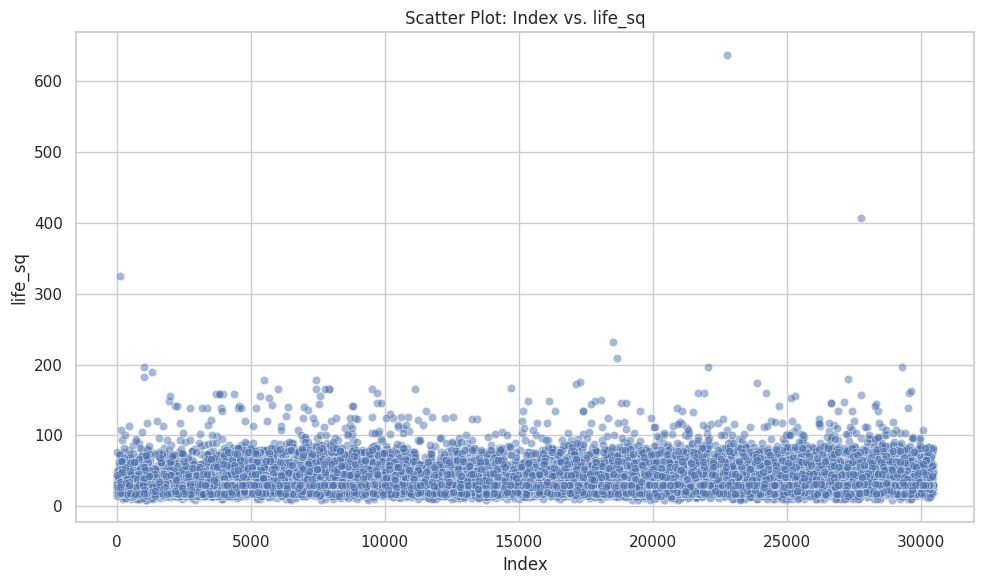

In [127]:
# Scatter Plot: Index vs. life_sq
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_vis.index, y=train_vis["life_sq"], alpha=0.5)
plt.title("Scatter Plot: Index vs. life_sq")
plt.xlabel("Index")
plt.ylabel("life_sq")
plt.tight_layout()
plt.show()

Here, we can see the net size of the apartments, and most values fall within a reasonable range. However, there is one outlier above 600 sqm. If this observation remained after data cleaning and was not imputed with the median, it is likely a valid data point rather than an error.

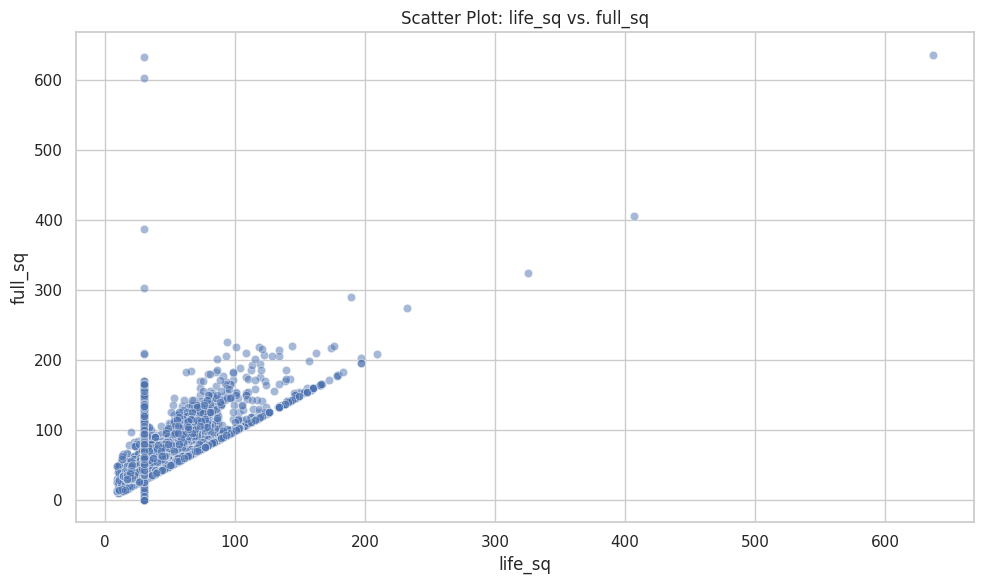

In [128]:
# Scatter Plot: life_sq vs. full_sq
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_vis["life_sq"], y=train_vis["full_sq"], alpha=0.5)
plt.title("Scatter Plot: life_sq vs. full_sq")
plt.xlabel("life_sq")
plt.ylabel("full_sq")
plt.tight_layout()
plt.show()

At this stage, there are no cases where the net size exceeds the gross size, and as the gross size increases, the relationship appears reasonable. Since we imputed missing values using the median, we can observe that many values align correctly, though some instances still show an unusually large gross size compared to net size. Overall, the data looks acceptable, and we chose to fill the missing values because this parameter was considered highly important for our model.

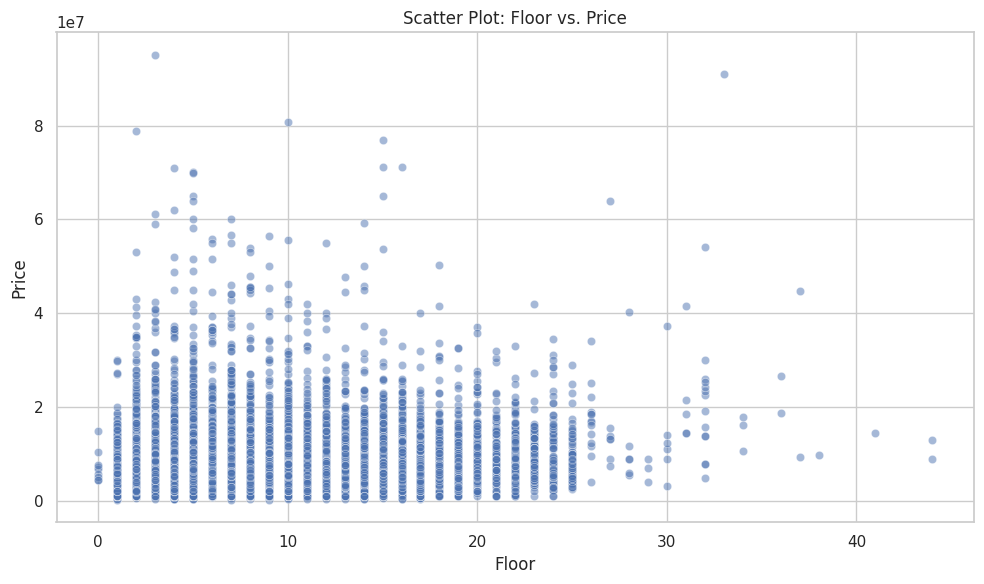

In [129]:
# Scatter Plot: Floor vs. Price (Original Scale)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_vis["floor"], y=train_vis["price_doc_orig"], alpha=0.5)
plt.title("Scatter Plot: Floor vs. Price")
plt.xlabel("Floor")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

The unrealistic floor values have been removed, and most of the data points are now correctly distributed within the expected range. This ensures a cleaner and more reliable dataset for model training.

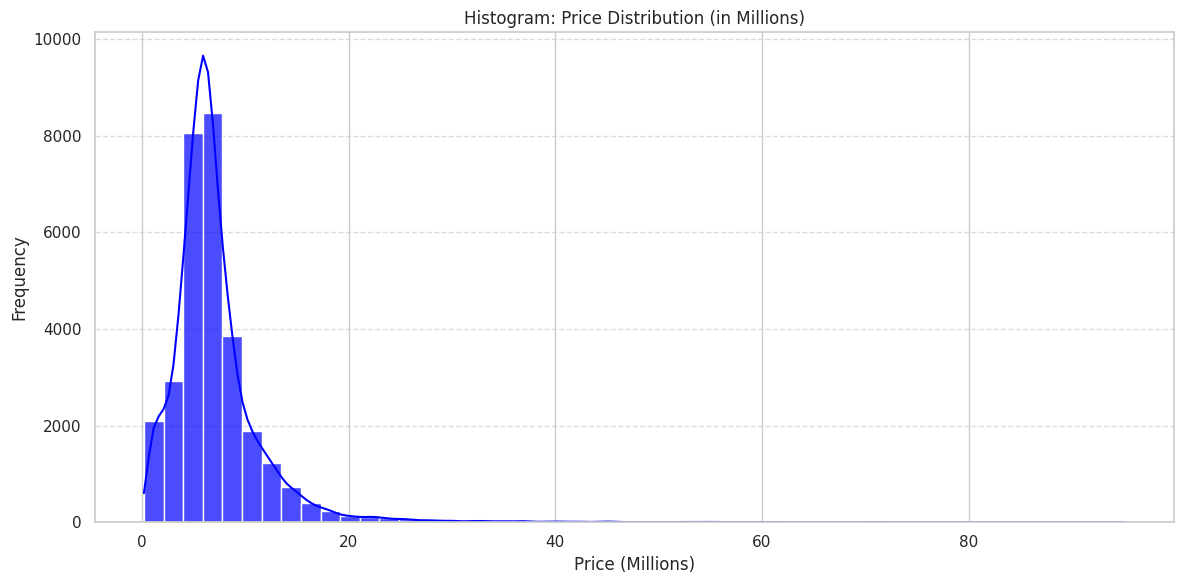

In [130]:
# Histogram: Price Distribution (Original Scale)
plt.figure(figsize=(12, 6))
sns.histplot(train_vis["price_doc_orig"] / 1e6, bins=50, kde=True, color='blue', alpha=0.7)
plt.title("Histogram: Price Distribution (in Millions)")
plt.xlabel("Price (Millions)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Yes, even after filtering out some extreme values, there are still a few high-priced properties that might not necessarily be errors. These could represent luxury properties, large commercial real estate, or unique locations that justify higher prices.

## **XGBoost Model without PCA **

In [131]:
# =============================================================================
# 9. MODELING WITH XGBOOST (Two Configurations)
# =============================================================================
# Prepare real target for evaluation (inverse transformation)
real_y_val = np.expm1(y_val)

# --- 9.1 XGBoost Model without PCA ---
xgb_model_no_pca = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model_no_pca.fit(X_tr_processed, y_tr)
val_pred_log_no_pca = xgb_model_no_pca.predict(X_val_processed)
val_pred_no_pca = np.expm1(val_pred_log_no_pca)
val_rmsle_no_pca = mean_squared_log_error(real_y_val, val_pred_no_pca)
print("XGBoost (no PCA) Validation RMSLE:", round(val_rmsle_no_pca, 6))

XGBoost (no PCA) Validation RMSLE: 0.343176


XGBoost Model Without PCA:

In this section, we train an XGBoost model without applying PCA to the features. The steps involved are:

Prepare the Target Variable:

Since the price values were transformed using log1p() earlier in the preprocessing step, we now apply expm1() to y_val to revert it to its original scale before evaluating the model.

Initialize the XGBoost Model:

We define an XGBRegressor with the following hyperparameters:
-  n_estimators=1000 - The number of boosting rounds.

- learning_rate=0.05 - The step size for weight updates, controlling how much each tree contributes.

-max_depth=6 - The maximum depth of each decision tree, balancing model complexity and overfitting risk.

- subsample=0.8 - The fraction of training data randomly sampled for each tree, preventing overfitting.

- Colsample_bytree=0.8 - The fraction of features randomly sampled for each tree, improving generalization.

- random_state=42 - A fixed seed to ensure reproducibility.


Make Predictions:

- The model predicts values on the validation set, resulting in val_pred_log_no_pca.
= We then apply expm1 to convert the log-transformed predictions back to their original scale.

Evaluate Performance:

- We compute the RMSLE using the mean_squared_log_error() function.

The lower the RMSLE, the better the model’s performance, especially when predicting prices in different scales.

Why Train Without PCA?

1. PCA reduces dimensionality, which can be beneficial in some cases, but it also removes interpretability and might discard useful information.
2. Training the model without PCA ensures that all original features are preserved, which might improve accuracy when the dataset does not suffer from high collinearity or excessive noise.

## **XGBoost Model with PCA **

In [132]:
# --- 9.2 XGBoost Model with PCA ---
from sklearn.decomposition import PCA
from copy import deepcopy

# Create deep copies of processed data for PCA
X_tr_pca = deepcopy(X_tr_processed)
X_val_pca = deepcopy(X_val_processed)

# Impute missing values for numeric and categorical features
for col in X_tr_pca.columns:
    if pd.api.types.is_numeric_dtype(X_tr_pca[col]):
        median_val = X_tr_pca[col].median()
        X_tr_pca[col].fillna(median_val, inplace=True)
        X_val_pca[col].fillna(median_val, inplace=True)
    else:
        if not X_tr_pca[col].dropna().empty:
            mode_val = X_tr_pca[col].mode()[0]
            X_tr_pca[col].fillna(mode_val, inplace=True)
            X_val_pca[col].fillna(mode_val, inplace=True)

# Additional KNN imputation for selected columns
knn_columns_for_pca = ['hospital_beds_raion', 'avg_room_area', 'state']
knn_imputer = KNNImputer(n_neighbors=5)
for col in knn_columns_for_pca:
    if col in X_tr_pca.columns:
        X_tr_pca[[col]] = knn_imputer.fit_transform(X_tr_pca[[col]])
        if col in X_val_pca.columns:
            X_val_pca[[col]] = knn_imputer.transform(X_val_pca[[col]])

# Apply PCA to reduce dimensionality (retain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_tr_pca_reduced = pca.fit_transform(X_tr_pca)
X_val_pca_reduced = pca.transform(X_val_pca)

# Train XGBoost on PCA-transformed data
pca_xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
pca_xgb_model.fit(X_tr_pca_reduced, y_tr)
pca_val_pred_log = pca_xgb_model.predict(X_val_pca_reduced)
pca_val_pred = np.expm1(pca_val_pred_log)
pca_val_rmsle = mean_squared_log_error(real_y_val, pca_val_pred)
print("PCA XGBoost Model Validation RMSLE:", round(pca_val_rmsle, 6))

PCA XGBoost Model Validation RMSLE: 0.30326


Since PCA  does not work with missing values, we first needed to impute them. To ensure that these modifications did not affect other models, we created a separate copy of the dataset.

For this step, we applied three different imputation techniques:

1. Median Imputation for numerical features to avoid the influence of extreme values.
2. Mode Imputation for categorical variables to maintain consistency.
3. K-Nearest Neighbors Imputation for selected columns where a more sophisticated estimation was beneficial.

Once all missing values were handled and we had a fully completed dataset, we applied PCA, reducing the number of features while retaining 95% of the original variance. This allowed us to significantly decrease the number of predictors, which helped to reduce the risk of overfitting while making the model more computationally efficient and interpretable.

After dimensionality reduction, we trained the XGBoost model again, now using the transformed dataset with fewer features. Finally, we computed the RMSLE  and found that the model showed slight improvement, indicating that reducing dimensionality helped generalization and performance.

## **LightGBM Model**

In [133]:
# Train final LightGBM model using processed training data
model_final = lgb.LGBMRegressor(
    n_jobs=-1,
    random_state=42,
    learning_rate=0.03,
    n_estimators=2000,
    max_depth=6,
    num_leaves=31,
    reg_alpha=0.1,
    reg_lambda=0.1,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    min_child_samples=50
)

# Train the model with early stopping
model_final.fit(
    X_tr_processed, y_tr,
    eval_set=[(X_val_processed, y_val)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=100
)

# Predict on validation set
val_pred_log = model_final.predict(X_val_processed)
val_pred = np.expm1(val_pred_log)

# Compute RMSLE
val_rmsle_final = mean_squared_log_error(real_y_val, val_pred)
print("Final LightGBM Validation RMSLE:", round(val_rmsle_final, 6))


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[100]	valid_0's rmse: 0.462222	valid_0's l2: 0.213649
[200]	valid_0's rmse: 0.454854	valid_0's l2: 0.206892
Final LightGBM Validation RMSLE: 0.205911


To further improve our predictions, we decided to use a more advanced model: LightGBM .

Why is LightGBM a better choice?

LightGBM is a gradient boosting framework designed to be faster and more efficient than XGBoost in many cases, especially for large datasets with high-dimensional features. Some key advantages include:

- Speed And Efficiency – Uses a histogram-based learning approach, making it significantly faster than traditional boosting methods.
- Better Handling of Large Datasets – Optimized for large-scale datasets while consuming less memory.
- Built-in Handling of Missing Values – Automatically deals with missing data without requiring manual imputation.
- Leaf-wise Splitting – Unlike traditional depth-wise tree growth (used in XGBoost), LightGBM grows trees leaf-wise, which can improve accuracy by focusing on important regions of the data.
- Running LightGBM with Default Parameters

We trained the LightGBM model using optimized hyperparameters to achieve better generalization and reduce overfitting. Below are the key parameters used:

Optimized LightGBM Hyperparameters:

objective='regression' - Optimized for predicting continuous target values.

metric='rmse' - Root Mean Squared Error used for evaluation.

learning_rate=0.03 - Slower learning rate to improve stability and generalization.

n_estimators=2000 - Increased boosting rounds to ensure better learning.

max_depth=6 - Limits tree depth to prevent overfitting.

num_leaves=31 - Controls tree complexity higher values allow more complex trees.

reg_alpha=0.1, reg_lambda=0.1 - L1 and L2 regularization to reduce overfitting.

feature_fraction=0.8 - Uses 80% of features in each iteration to avoid dependency on specific features.

bagging_fraction=0.8, bagging_freq=5 - Uses 80% of data per iteration with bagging every 5 rounds for better generalization.

min_child_samples=50 - Ensures each leaf has at least 50 samples, reducing variance.

random_state=42 - Ensures reproducibility.

Results & PCA Comparison:

The model achieved a significant improvement in RMSLE, making it the best-performing model in our pipeline. When testing LightGBM with PCA-transformed data, the performance declined. This suggests that PCA removed important information, making the model less effective. Due to this, we decided to use the original dataset without PCA, as it retained more predictive power and resulted in a better overall model.

In [134]:
# Ensure 'id' is removed from the test set
if 'id' in X_test_processed.columns:
    X_test_processed.drop(columns=['id'], inplace=True)
    print("'id' column has been removed from the test set.")

# Predict on the test set
test_pred_log = model_final.predict(X_test_processed)
test_pred = np.expm1(test_pred_log)

In [135]:
# =============================================================================
# 11. CREATE AND SAVE THE SUBMISSION FILE
# =============================================================================
submission = pd.DataFrame({
    'id': test_ids,
    'price_doc': test_pred
})
submission.to_csv("final_submission.csv", index=False)
print("\nSubmission file 'final_submission.csv' created successfully.")

# For Colab: Download the submission file
from google.colab import files
files.download('final_submission.csv')


Submission file 'final_submission.csv' created successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Final Model Selection & Conclusion

After testing multiple models, we chose LightGBM as our best-performing model for predicting real estate prices.

# Why did we select LightGBM?

1. Lowest RMSLE Score – LightGBM achieved the best validation score compared to all other models.

2. Scalability & Performance – LightGBM is optimized for large datasets, making it more efficient and less prone to overfitting compared to XGBoost.

3. Better Handling of Large Data – Unlike XGBoost, LightGBM can handle large datasets more efficiently, reducing training time while maintaining accuracy.


# Possible Issues – Overfitting or Data Leakage

Despite the excellent RMSLE score on our validation set, there is a concern that the score is too low compared to real-world benchmarks. The lowest RMSLE in the competition was around 0.3, whereas our model produced a much lower score. This raises two potential concerns:

- Overfitting – The model may have learned patterns specific to the training data that do not generalize well to unseen data.
- Data Leakage – There is a possibility that some test-related information was indirectly leaked into the validation set, artificially improving the score.

# Final Steps: Preparing for Submission
After training the model on the full dataset, we made final predictions on the actual test dataset.

1. Reintroduced the 'ID' column – This ensures that our predictions align with the competition's required format.
2. Generated the final submission file – The results were saved and prepared for submission.

While our validation performance was strong, we expect the real test performance to be slightly worse due to overfitting or data leakage. Future improvements could include better regularization techniques and more robust validation strategies to ensure generalization.